LIBRARY

In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

FOR DATA DISPLAY 

number of images found:  1000000
Number of images found:  200000
Shape of image:  (50, 350, 3)
Shape of image:  (50, 350, 3)
Shape of image:  (50, 350, 3)
Shape of image:  (50, 350, 3)


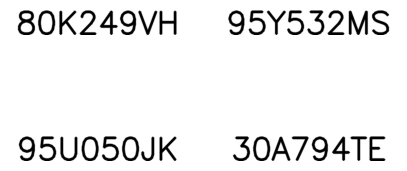

In [2]:
# Path to the data directory
data_dir = Path(r"/kaggle/input/car-numbers-without-noises/images")
images = os.listdir(data_dir)

print('number of images found: ', len(images))
os.chdir(r"/kaggle/input/car-numbers-without-noises/images")

# Get list of all the images
images = list(data_dir.glob("*.png"))
images = images[:200000]

print("Number of images found: ", len(images))

# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

FOR CHEKING LABELS

In [3]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  36
Maximum length of any captcha:  8
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total number of samples in the dataset:  200000


,img_path,label
0,/kaggle/input/car-numbers-without-noises/image...,85G786TL
1,/kaggle/input/car-numbers-without-noises/image...,95N602OG
2,/kaggle/input/car-numbers-without-noises/image...,30K821MT
3,/kaggle/input/car-numbers-without-noises/image...,10R535EP
4,/kaggle/input/car-numbers-without-noises/image...,60A342DJ


In [4]:

training_data, validation_data = train_test_split(dataset, test_size=0.02, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}

def generate_arrays(df, resize=False, img_height=50, img_width=350):
    num_items = len(df)

    labels = []
    images = []
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = (img/255.).astype(np.float32)
        labels.append(df["label"][i])
        images.append(img)

        
    return np.array(images), np.array(labels)

training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  196000
Number of validation samples:  4000
Number of training images:  (196000, 50, 350)
Number of training labels:  (196000,)
Number of validation images:  (4000, 50, 350)
Number of validation labels:  (4000,)


In [5]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=128,
                 img_width=350,
                 img_height=50,
                 downsample_factor=4,
                 max_length=8,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            label = [self.char_map[ch] for ch in text]
            batch_images[j] = img
            batch_labels[j] = label
            label_length[j] = len(text)
            
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [6]:
# Batch size for training and validation
batch_size = 128

# Desired image dimensions
img_width=350
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=8

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.002,
                                     decay=1e-6,
                                     momentum=0.9,
                                     nesterov=True,
                                     clipnorm=8)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

In [8]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 350, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 350, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 175, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 175, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [10]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=10,
                    callbacks=[es])

Epoch 1/10
1532/1532 [==============================] - 163s 106ms/step - loss: 5.5825e-04 - val_loss: 3.3338e-04
Epoch 2/10
1532/1532 [==============================] - 163s 106ms/step - loss: 4.6334e-04 - val_loss: 3.3985e-04
Epoch 3/10
1532/1532 [==============================] - 163s 106ms/step - loss: 4.4224e-04 - val_loss: 3.1916e-04
Epoch 4/10
1532/1532 [==============================] - 163s 106ms/step - loss: 3.5357e-04 - val_loss: 3.1547e-04
Epoch 5/10
1532/1532 [==============================] - 162s 106ms/step - loss: 3.4320e-04 - val_loss: 3.1368e-04
Epoch 6/10
1532/1532 [==============================] - 161s 105ms/step - loss: 3.5860e-04 - val_loss: 3.1494e-04
Epoch 7/10
1532/1532 [==============================] - 159s 104ms/step - loss: 3.8232e-04 - val_loss: 3.1306e-04
Epoch 9/10
1532/1532 [==============================] - 158s 103ms/step - loss: 3.3565e-04 - val_loss: 3.1150e-04
Epoch 10/10
1532/1532 [==============================] - 158s 103ms/step - loss: 3.4047e

In [24]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 350, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 350, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 175, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 175, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 87, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 87, 768)           0         
                                                                 
 dense1 (Dense)              (None, 87, 64)            4921

In [12]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [13]:
n=0
true=0
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        n+=1
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')

        if orig_texts[i] ==pred_texts[i]:
            print(f'{n}True')
        else:
            print(f'{n}False')

        if orig_texts[i] ==pred_texts[i]:
            true+=1
            
    print(true)

    break

4/4 [==============================] - 1s 10ms/step
Ground truth: 60V303AT 	 Predicted: 60V303AT
1True
Ground truth: 50K352NN 	 Predicted: 50K352NN
2True
Ground truth: 70X696MV 	 Predicted: 70X696MV
3True
Ground truth: 60Z939GV 	 Predicted: 60Z939GV
4True
Ground truth: 60B148VS 	 Predicted: 60B148VS
5True
Ground truth: 30M667WN 	 Predicted: 30M667WN
6True
Ground truth: 10W010QT 	 Predicted: 10W010QT
7True
Ground truth: 40R821IC 	 Predicted: 40R821IC
8True
Ground truth: 10W529WO 	 Predicted: 10W529WO
9True
Ground truth: 85U475OD 	 Predicted: 85U475OD
10True
Ground truth: 95U862BN 	 Predicted: 95U862BN
11True
Ground truth: 80N821YU 	 Predicted: 80N821YU
12True
Ground truth: 80Q754CP 	 Predicted: 80Q754CP
13True
Ground truth: 10N163MA 	 Predicted: 10N163MA
14True
Ground truth: 90V980EP 	 Predicted: 90V980EP
15True
Ground truth: 20A639UG 	 Predicted: 20A639UG
16True
Ground truth: 01W569YL 	 Predicted: 01W569YL
17True
Ground truth: 50U581HU 	 Predicted: 50U581HU
18True
Ground truth: 01P533Z

**Please upvote if you liked the notebook.**